In [30]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys
from pathlib import Path
import copy

# test

import matplotlib.pyplot as plt
%matplotlib inline

# path to stylegan encoder on server
sys.path.insert(1, '/home/shavit/APhotoADay/data/stylegan-encoder')

from encoder.generator_model import Generator
import dnnlib
import dnnlib.tflib as tflib
import config

from IPython.display import Markdown, display

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [31]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

printmd("Please enter number of dimensions:", color="blue")

dimensions = int(input())

<span style='color:blue'>Please enter number of dimensions:</span>

 180


In [39]:
# Load Data

# data is a list of lists where the first element is the age and the second is the latent representation

# i.e. data[0] contains the entire first video
# data[0][0] is a list of two values (the first age of the video, and the latent representation of the photo at that age)

data = []

video = []

paths = ["regression_data/video1",
         "regression_data/video2",
         "regression_data/video3"]

for path in paths:
    
    for photo in os.listdir(path):

        latent_representation = np.load(path + "/" + photo).flatten()
        age = int(Path(photo).stem)

        video.append([age, latent_representation])
        video.sort()
        
    data.append(video)
    video = []

In [40]:
# Find most linear components in data

# find differences
differences = []

for person in data:
    for j, photo in enumerate(person):
        if j == 0:
            continue
        differences.append(photo[1] - person[j - 1][1])

differences = np.array(differences)

differences_aux = differences.transpose()

normalized_differences_aux = preprocessing.normalize(np.array(differences_aux))

variances = []
normalized_variances = []

for values in differences_aux:
    variances.append(np.var(values))

for values in normalized_differences_aux:
    normalized_variances.append(np.var(values))
    
# list of components sorted by variance
smallest_variance_components = np.argsort(variances)
normalized_smallest_variance_components = np.argsort(normalized_variances)

In [41]:
data_first_10 = copy.deepcopy(data)
data_most_linear = copy.deepcopy(data)
data_normalized_most_linear = copy.deepcopy(data)

In [42]:
for i, person in enumerate(data_first_10):
    for j, photo in enumerate(person):
        #print ("first 10 = ")
        #print (data_first_10[i][j][1][0:10])
        data_first_10[i][j][1] =  np.concatenate((data_first_10[i][j][1][0:dimensions], np.zeros(512*18 - dimensions)))

In [43]:
smallest_variance_components = np.concatenate((smallest_variance_components[0:dimensions], np.ones(512*18 - dimensions) * (-1)))

for i, person in enumerate(data_most_linear):
    for j, photo in enumerate(person):
        for k, component in enumerate(photo[1]):
            if (k in smallest_variance_components) == False:
                data_most_linear[i][j][1][k] = 0

In [44]:
normalized_smallest_variance_components = np.concatenate((normalized_smallest_variance_components[0:dimensions], np.ones(512*18 - dimensions) * (-1)))

for i, person in enumerate(data_normalized_most_linear):
    for j, photo in enumerate(person):
        for k, component in enumerate(photo[1]):
            if (k in normalized_smallest_variance_components) == False:
                data_normalized_most_linear[i][j][1][k] = 0

In [45]:
def findRegressor(start_ages, start_photos, target_ages, target_photos):

    X = []
    Y = []

    for i in range(len(start_photos)):
        X.append(np.concatenate([start_photos[i], start_ages[i], target_ages[i]], axis=None))
        Y.append(target_photos[i] - start_photos[i])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    regressor = LinearRegression(copy_X = True)  
    regressor.fit(X_train, Y_train)

    #print("accuracy = " + str(testModel(X_train, Y_train, regressor)))

    return regressor, np.array(X_test).astype(np.float64), np.array(Y_test).astype(np.float64), np.array(X_train).astype(np.float64), np.array(Y_train).astype(np.float64)

In [46]:
# Regression for first 10 dimensions
start_ages_f10 = []
start_photos_f10 = []
target_ages_f10 = []
target_photos_f10 = []

for person in data_first_10:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_f10.append(first_photo)
        start_ages_f10.append(first_age)
        target_ages_f10.append(photo[0])
        target_photos_f10.append(photo[1])

regressor_first_10, X_test_f10, Y_test_f10, X_train_f10, Y_train_f10 = findRegressor (start_ages_f10, start_photos_f10, target_ages_f10, target_photos_f10)


In [47]:
predicted_differences_f10 = regressor_first_10.predict(X_test_f10)
predicted_results_f10 = []
for i, difference in enumerate(predicted_differences_f10):
    predicted_results_f10.append(start_photos_f10[i] + difference)
MSE_f10 = metrics.mean_squared_error (Y_test_f10, predicted_results_f10)
predicted_differences_f10_train = regressor_first_10.predict(X_train_f10)
predicted_results_f10_train = []
for i, difference in enumerate(predicted_differences_f10_train):
    predicted_results_f10_train.append(start_photos_f10[i] + difference)
MSE_f10_train = metrics.mean_squared_error (predicted_differences_f10_train, Y_train_f10)

print (MSE_f10_train)
print (MSE_f10)

6.776632811865815e-05
0.0003423401012259137


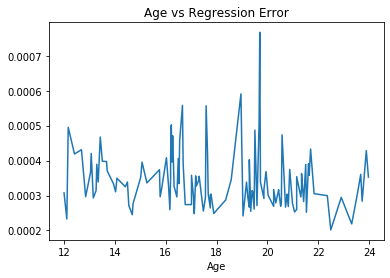

In [48]:
# New code
age_specific_MSE_f10 = []

for i, age in enumerate(Y_test_f10):
    this_MSE = metrics.mean_squared_error (Y_test_f10[i], predicted_results_f10[i])
    age_specific_MSE_f10.append([X_test_f10[i][512*18 + 1], this_MSE])

age_specific_MSE_f10.sort()

graph_name = "regression_data/graphs/dimensions/graph1_f10"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_f10:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [49]:
# Regression for smallest variance
start_ages_sv = []
start_photos_sv = []
target_ages_sv = []
target_photos_sv = []

for person in data_most_linear:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_sv.append(first_photo)
        start_ages_sv.append(first_age)
        target_ages_sv.append(photo[0])
        target_photos_sv.append(photo[1])

regressor_smallest_variance, X_test_sv, Y_test_sv, X_train_sv, Y_train_sv = findRegressor (start_ages_sv, start_photos_sv, target_ages_sv, target_photos_sv)


In [50]:
predicted_differences_sv = regressor_smallest_variance.predict(X_test_sv)
predicted_results_sv = []
for i, difference in enumerate(predicted_differences_sv):
    predicted_results_sv.append(start_photos_sv[i] + difference)
MSE_sv = metrics.mean_squared_error (Y_test_sv, predicted_results_sv)
predicted_differences_sv_train = regressor_smallest_variance.predict(X_train_sv)
predicted_results_sv_train = []
for i, difference in enumerate(predicted_differences_sv_train):
    predicted_results_sv_train.append(start_photos_sv[i] + difference)
MSE_sv_train = metrics.mean_squared_error (predicted_differences_sv_train, Y_train_sv)

print (MSE_sv_train)
print (MSE_sv)

2.9424906584471456e-05
9.928224425306691e-05


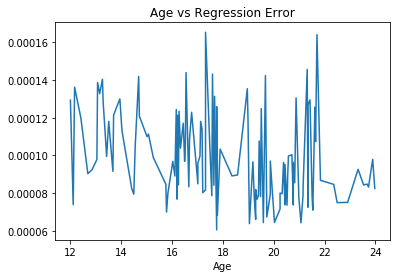

In [51]:
# New code
age_specific_MSE_sv = []

for i, age in enumerate(Y_test_sv):
    this_MSE = metrics.mean_squared_error (Y_test_sv[i], predicted_results_sv[i])
    age_specific_MSE_sv.append([X_test_sv[i][512*18 + 1], this_MSE])

age_specific_MSE_sv.sort()

graph_name = "regression_data/graphs/dimensions/graph1_sv"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_sv:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [52]:
# Regression for smallest variance
start_ages_nsv = []
start_photos_nsv = []
target_ages_nsv = []
target_photos_nsv = []

for person in data_normalized_most_linear:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_nsv.append(first_photo)
        start_ages_nsv.append(first_age)
        target_ages_nsv.append(photo[0])
        target_photos_nsv.append(photo[1])

regressor_normalized_smallest_variance, X_test_nsv, Y_test_nsv, X_train_nsv, Y_train_nsv = findRegressor (start_ages_nsv, start_photos_nsv, target_ages_nsv, target_photos_nsv)


In [53]:
predicted_differences_nsv = regressor_normalized_smallest_variance.predict(X_test_nsv)
predicted_results_nsv = []
for i, difference in enumerate(predicted_differences_nsv):
    predicted_results_nsv.append(start_photos_nsv[i] + difference)
MSE_nsv = metrics.mean_squared_error (Y_test_nsv, predicted_results_nsv)
predicted_differences_nsv_train = regressor_normalized_smallest_variance.predict(X_train_nsv)
predicted_results_nsv_train = []
for i, difference in enumerate(predicted_differences_nsv_train):
    predicted_results_nsv_train.append(start_photos_nsv[i] + difference)
MSE_nsv_train = metrics.mean_squared_error (predicted_differences_nsv_train, Y_train_nsv)

print (MSE_nsv_train)
print (MSE_nsv)

0.0003489349735451796
0.0006517990023684949


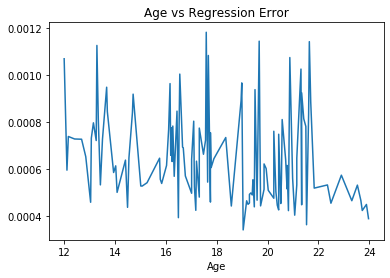

In [54]:
# New code
age_specific_MSE_nsv = []

for i, age in enumerate(Y_test_nsv):
    this_MSE = metrics.mean_squared_error (Y_test_nsv[i], predicted_results_nsv[i])
    age_specific_MSE_nsv.append([X_test_nsv[i][512*18 + 1], this_MSE])

age_specific_MSE_nsv.sort()

graph_name = "regression_data/graphs/dimensions/graph1_nsv"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_nsv:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [55]:
# predicted_results_f10
# predicted_results_sv
# predicted_results_nsv

In [59]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
    
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node G_synthesis_5/64x64/Conv1/weight/Assign (defined at <string>:140) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'G_synthesis_5/64x64/Conv1/weight/Assign':
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/asyncio/base_events.py", line 442, in run_forever
    self._run_once()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/asyncio/base_events.py", line 1462, in _run_once
    handle._run()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-a7d3c01419dc>", line 5, in <module>
    generator_network, discriminator_network, Gs_network = pickle.load(f)
  File "/home/shavit/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 298, in __setstate__
    self._init_graph()
  File "/home/shavit/APhotoADay/data/stylegan-encoder/dnnlib/tflib/network.py", line 155, in _init_graph
    out_expr = self._build_func(*self.input_templates, **build_kwargs)
  File "<string>", line 531, in G_synthesis
  File "<string>", line 513, in block
  File "<string>", line 157, in conv2d
  File "<string>", line 140, in get_weight
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1496, in get_variable
    aggregation=aggregation)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1239, in get_variable
    aggregation=aggregation)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 562, in get_variable
    aggregation=aggregation)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 514, in _true_getter
    aggregation=aggregation)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 929, in _get_single_variable
    aggregation=aggregation)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2511, in default_variable_creator
    shape=shape)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1568, in __init__
    shape=shape)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1745, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 227, in assign
    validate_shape=validate_shape)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 66, in assign
    use_locking=use_locking, name=name)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [57]:
def generate_image(latent_vector, size):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((size, size))

In [58]:
# Video from given picture, using our data (which specific data exactly?)

os.chdir("/home/shavit/APhotoADay/True_vs_Learned")

t_start_photos = []
t_start_ages = []
t_target_ages = []
    
t_first = np.load("regression_data/test/kobi.npy").flatten()
t_first_age = int(input("Enter your age (years): ")) * 365
t_first_age = 20 * 365

for i in range (t_first_age, t_first_age * 2, 10):
    t_start_photos.append(t_first)
    t_start_ages.append(t_first_age)
    t_target_ages.append(i)

t_X = []
for i in range(len(t_start_photos)):
    t_X.append(np.concatenate([t_start_photos[i], t_start_ages[i], t_target_ages[i]], axis=None))

methods = ["first", "linear_first", "norm_linear_first"]    
paths = []

for method in methods:
    
    results_path = "regression_data/results/dimensions/" + method + "_" + str(dimensions)
    paths.append(results_path)
    
    t_Y_differences = regressor_first_10.predict(t_X)
    if method == "linear_first":
        t_Y_differences = regressor_smallest_variance.predict(t_X)
    if method == "norm_linear_first":
        t_Y_differences = regressor_normalized_smallest_variance.predict(t_X)
    
    t_Y = []

    for i, difference in enumerate(t_Y_differences):
        t_Y.append(t_start_photos[i] + difference)

    if not os.path.exists(results_path):
        os.mkdir(results_path)

    frames = 60

    for i, prediction in enumerate(t_Y):
        img = generate_image(prediction, 512)
        img.save(results_path + "/" + str(i) + ".png")
        frames = i

    print(frames)

Enter your age (years):  20


NameError: name 'generator' is not defined

In [ ]:
import math
framerate = math.ceil(frames / 6.0)

In [ ]:
# ffmpeg -f image2 -framerate 119 -pattern_type sequence -start_number 0 -r 2 -i %d.png -vcodec libx264 -acodec aac real_broken.mp4
# ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4
# ffmpeg -itsscale 0.027 -i real.mp4 -c copy real_output.mp4
# os.getcwd()
# First, manually check current path and if it is a father folder, execute chdir 

for path in paths:

    os.chdir("/home/shavit/APhotoADay/True_vs_Learned/" + path)

    res1 = os.system("ffmpeg -f image2 -framerate " + str(framerate) + " -pattern_type sequence -start_number 0 -r 2 -i %d.png -vcodec libx264 -acodec aac real_broken.mp4")
    
    if res1 == 0:
        res2 =os.system("ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4")
        
        if res2 == 0:
            res3 = os.system("ffmpeg -itsscale 0.027 -i real.mp4 -c copy output.mp4")
            
            if res3 == 0:
                os.system("rm real_broken.mp4")
                os.system("rm real.mp4")
    